In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

Welcome to JupyROOT 6.18/00


In [2]:
outstr = 'cb'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/21_08_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')            

# Prepare time data for the minimization

In [4]:
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]

In [ ]:
dict_df_energy = {}

for energy in energies:
    round_energy = round(float(energy),-1)
    if round_energy ==240 : round_energy = 250
        
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
        pos_cut = 4
    data = []
    for evt in tree:
        if evt.fit_ampl[getattr(evt, crystal)]>1000 and evt.fit_ampl[evt.MCP1]>100 and evt.fit_ampl[evt.MCP2]>100 and evt.n_tracks==1 and abs(evt.X[0]-dict_crystal_centers[crystal][0])<pos_cut and abs(evt.Y[0]-dict_crystal_centers[crystal][1])<pos_cut : 
            evt_dict = {}
            evt_dict['Energy'] = evt.Energy
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            for xstal in ['C3']:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['dt_ecal_mcp1_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_ecal_mcp2_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
                #evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
    
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%s.csv'%(trees_path,int(round_energy))
    df.to_csv(pd_name)


In [5]:
### Only used when I dont want to rerun the dataframe creation (takes longer than read csv file)
dict_df_energy = {}
for energy in energies:
    round_energy = round(float(energy),-1)
    if round_energy ==240 : round_energy = 250
    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%d.csv'%(trees_path,int(round_energy))
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

## Event selection

In [6]:
dt_cut = 200
#Event selection
for energy in energies:
    df = dict_df_energy[energy]
    selection = ((abs(df['dt_ecal_mcp2_C3']-df['dt_ecal_mcp2_C3'].median())<dt_cut) & 
                 (abs(df['dt_ecal_mcp1_C3']-df['dt_ecal_mcp1_C3'].median())<dt_cut) & 
                 (abs(df['dt_mcp2_mcp1_C3']-df['dt_mcp2_mcp1_C3'].median())<dt_cut))
    dict_df_energy[energy] = df.loc[selection]

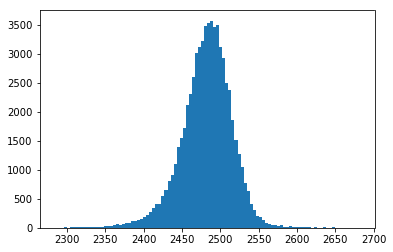

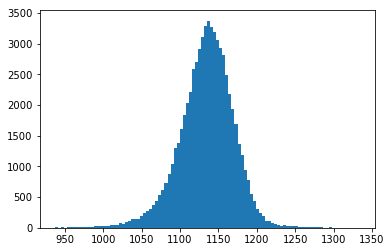

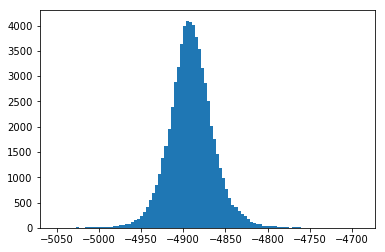

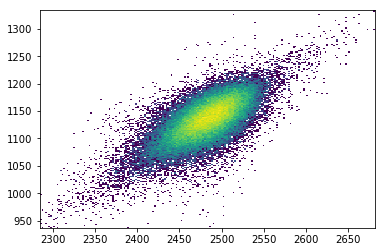

In [7]:
df = dict_df_energy[energies[-1]]  #which energy to plot

selection = (abs(df['dt_ecal_mcp2_C3']-df['dt_ecal_mcp2_C3'].median())<200) & (abs(df['dt_ecal_mcp1_C3']-df['dt_ecal_mcp1_C3'].median())<200) & (abs(df['dt_mcp2_mcp1_C3']-df['dt_mcp2_mcp1_C3'].median())<200)

plt.hist(df.loc[selection, 'dt_ecal_mcp1_C3'], bins=100)
plt.show()
plt.hist(df.loc[selection, 'dt_ecal_mcp2_C3'], bins=100)
plt.show()
plt.hist(df.loc[selection, 'dt_mcp2_mcp1_C3'], bins=100)
plt.show()
plt.hist2d(df.loc[selection, 'dt_ecal_mcp1_C3'], df.loc[selection, 'dt_ecal_mcp2_C3'], bins=[200,200], norm=colors.LogNorm())
plt.show()


In [8]:
gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')


0

In [14]:
results_params = {}
for energy in energies:
    print 'Analyzing energy ',energy
    df = dict_df_energy[energy]
    time_minimizer = ROOT.LLminimizer(df['fit_ampl_MCP1'].shape[0],array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])),array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),array('d',list(df['dt_mcp2_mcp1_C3'])),crystal,energy)
    time_minimizer.MinimizeNLL()
    res = {}
    res['Cm'] = [time_minimizer.m_Cm_,time_minimizer.m_Cm_e_]
    res['a1'] = [time_minimizer.m_a1_,time_minimizer.m_a1_e_]
    res['b1'] = [time_minimizer.m_b1_,time_minimizer.m_b1_e_]
    res['a2'] = [time_minimizer.m_a2_,time_minimizer.m_a2_e_]
    res['b2'] = [time_minimizer.m_b2_,time_minimizer.m_b2_e_]
    res['alpha'] = [time_minimizer.m_alpha_,time_minimizer.m_alpha_e_]
    res['beta'] = [time_minimizer.m_beta_,time_minimizer.m_beta_e_]
    res['gamma'] = [time_minimizer.m_gamma_,time_minimizer.m_gamma_e_]   
    results_params[energy] = res


Analyzing energy  49.99
Analyzing energy  99.83
Analyzing energy  149.12
Analyzing energy  197.27
Analyzing energy  243.48


(49.99, {'Cm': [39.49688114906957, 0.190438018443146], 'a1': [863.2204641925224, 15.601437311652376], 'beta': [1224.4351369518529, 0.31103392292288845], 'a2': [964.5280948424291, 18.248310565934617], 'b1': [6.389759078225303, 1.2681602786607127], 'b2': [15.919328139189366, 0.5073677320692322], 'alpha': [2572.134310309468, 0.2909769105403939], 'gamma': [-4890.682366328197, 0.15526483634448596]})
(99.83, {'Cm': [30.81629034173555, 0.1785013014321759], 'a1': [838.3572021132184, 15.370651382104711], 'beta': [1166.7549216189655, 0.2770789609357962], 'a2': [939.7524852938203, 18.00132674563838], 'b1': [7.577270573999232, 0.7862610569999187], 'b2': [15.66461670095834, 0.36478055034397805], 'alpha': [2514.636689084761, 0.26066359275728246], 'gamma': [-4890.450833647244, 0.15496344302391662]})
(149.12, {'Cm': [29.386020708741828, 0.14363486504685596], 'a1': [851.9378204135993, 12.802362382140927], 'beta': [1151.5778426923282, 0.2245937598065666], 'a2': [964.7137247339533, 15.720367159628609], '

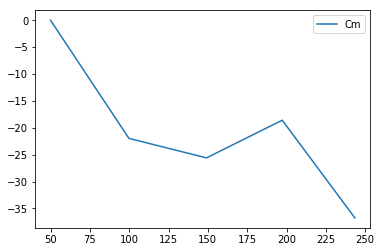

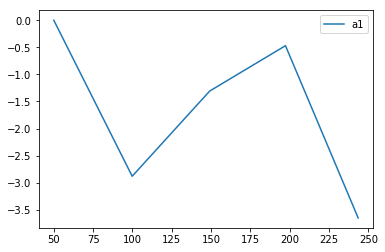

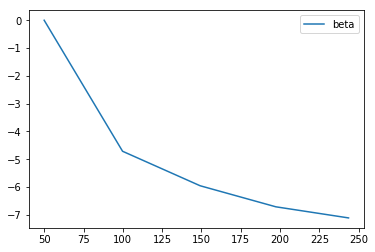

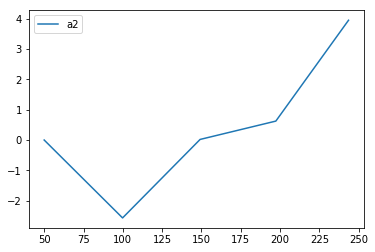

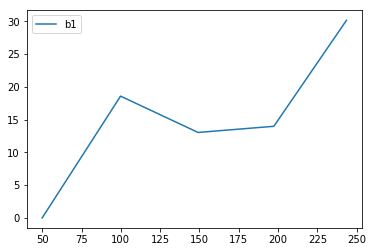

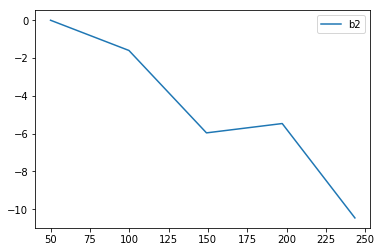

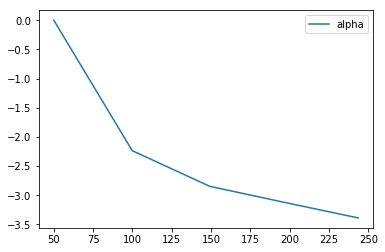

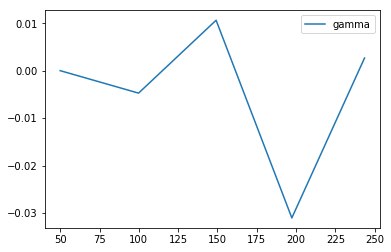

In [29]:
keys = [float(e) for e in results_params]
keys.sort()
params = {}
for k in keys:
    print(k, results_params[str(k)])
    for name,par in results_params[str(k)].items():
        if name not in params:
            params[name] = []
        params[name].append(par[0])
        
for name, par in params.items():        
    plt.plot(keys, [(v-par[0])/par[0]*100 for v in par], label=name)
    plt.legend()
    plt.show()
    


In [20]:
from scipy import stats
#print results_params
cm_res = array('d')
energies_float = array('d')
cm_e_res = array('d')
energies_float_e = array('d')

beam_scan_resolution = 0.005

for energy in energies:
    cm_res.append(results_params[energy]['Cm'][0])
    cm_e_res.append(results_params[energy]['Cm'][1])
    energies_float.append(dict_df_energy[energy]['fit_ampl_C3'].median()/dict_df_energy[energy]['noise_C3'].mean())
    energies_float_e.append(1.)

# Plot time resolution

In [21]:
gROOT.ProcessLineSync(".x utils/setTDRStyle.C")
gROOT.ForceStyle()
gStyle.SetPadTopMargin(0.06)
gStyle.SetPadRightMargin(0.04)
gStyle.SetPadLeftMargin(0.2)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


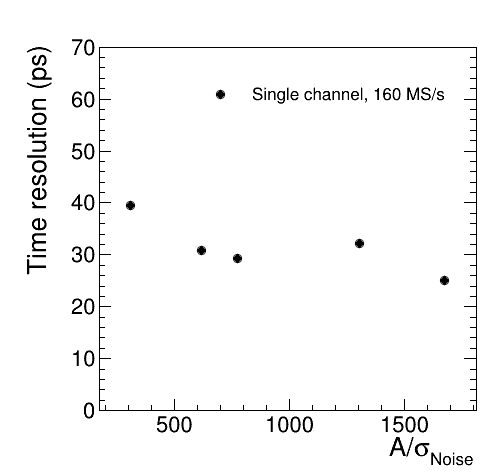

In [22]:
c1 = ROOT.TCanvas("c","c",500,500)
c1.SetTickx(0)


gres = ROOT.TGraphErrors(len(energies_float), energies_float , cm_res, energies_float_e, cm_e_res)
gres.SetTitle(";A/#sigma_{Noise}; Time resolution (ps)")
gres.Draw("AP")
gres.GetXaxis().SetNdivisions(507)
gres.GetYaxis().SetRangeUser(0, 70)
gres.Draw("AP")
st = gres.GetListOfFunctions().FindObject("stats")
#st.Delete()
lg = ROOT.TLegend(0.38, 0.7, 0.9, 0.9)
lg.AddEntry(gres, "Single channel, 160 MS/s", "p")
lg.SetFillStyle(-1)
lg.SetBorderSize(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.Draw("same")
c1.Draw()

c1.SetTopMargin(0.1)
c1.Draw()
#c1.SaveAs('%s/time_res_%s.pdf'%(plot_folder,outstr))
#c1.SaveAs('%s/time_res_%s.png'%(plot_folder,outstr))


## Plot time differences

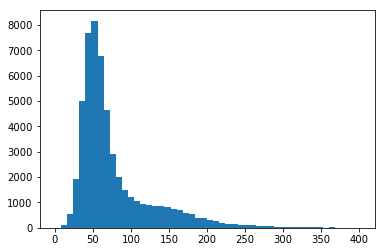

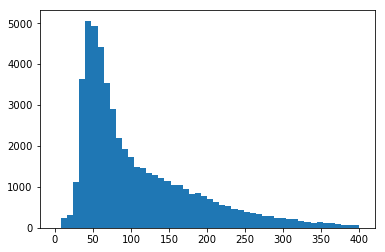

/usr/local/bin/start_ipykernel.py:18: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


2.166136154058186 9.002890616363604 -4889.6730844016165 27.385992845796466


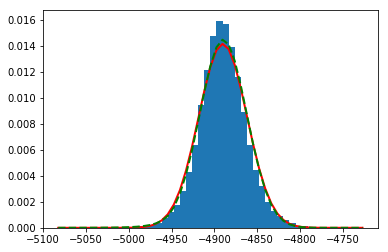

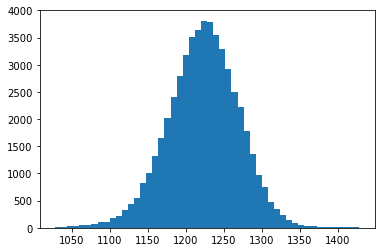

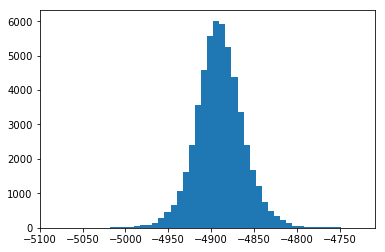

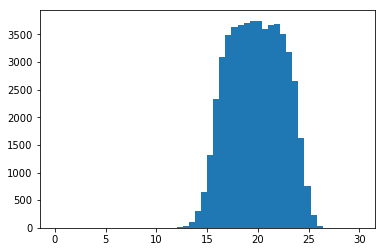

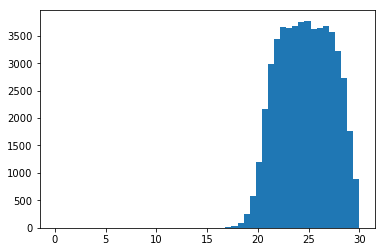

44.69972087432119


In [15]:
df = dict_df_energy[energies[0]]  #which energy to plot

plt.hist(list(df['fit_ampl_MCP1']),bins=50,range=[0,400])
plt.show()
plt.hist(list(df['fit_ampl_MCP2']),bins=50,range=[0,400])
plt.show()


from scipy.stats import norm
import matplotlib.mlab as mlab
#val = list(df.loc[(df.dt_ecal_mcp1_C3>2400) & (df.dt_ecal_mcp1_C3<2600)]['dt_ecal_mcp1_C3'])
val = list(df['dt_mcp2_mcp1_C3'])

n,bins,_ = plt.hist(val,bins=50,normed=1)
# best fit of data
(mu, sigma) = norm.fit(val,loc=2482.814488891773,scale=30.)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r-', linewidth=2)

from scipy.stats import crystalball
# best fit of data
beta, cb_m, loc, scale = crystalball.fit(val,loc=2482.814488891773,scale=30.)
# add a 'best fit' line
y = crystalball.pdf( bins, beta, cb_m, loc, scale)
l = plt.plot(bins, y, 'g--', linewidth=2)
print beta,cb_m,loc,scale
plt.show()


plt.hist(list(df['dt_ecal_mcp2_C3']),bins=50)
plt.show()
plt.hist(list(df['dt_mcp2_mcp1_C3']),bins=50)
plt.show()
plt.hist(list(df['fit_time_MCP2']),bins=50,range=[0,30])
plt.show()
plt.hist(list(df['fit_time_MCP1']),bins=50,range=[0,30])
plt.show()

print(df['dt_ecal_mcp1_C3'].std())

In [ ]:
for energy in energies:
    df = dict_df_energy[energy]
    print "dt1 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp1_C3'].mean(),df['dt_ecal_mcp1_C3'].std(),(df['dt_ecal_mcp1_C3'].quantile(0.75)-df['dt_ecal_mcp1_C3'].quantile(0.25))/2)
    print "dt2 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp2_C3'].mean(),df['dt_ecal_mcp2_C3'].std(),(df['dt_ecal_mcp2_C3'].quantile(0.75)-df['dt_ecal_mcp2_C3'].quantile(0.25))/2)
    print "dt12MCP : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_mcp2_mcp1_C3'].mean(),df['dt_mcp2_mcp1_C3'].std(),(df['dt_mcp2_mcp1_C3'].quantile(0.75)-df['dt_mcp2_mcp1_C3'].quantile(0.25))/2)
    print 

In [ ]:
loaded = np.load("data/ecal_time_resolution_160MHz_18deg_data.npz")
ampl = loaded["ampl"].item()
noise = loaded["noise"].item()
dt = loaded["dt"].item()
res_mcp = loaded["res_mcp"].item()

e_spectra = {}
e_fitfuncs = {}
for e, values in ampl.items():
    e_spectra[e] = ROOT.TH1F('spectrum_'+e, '', 200, values.mean()-3*values.std(), values.mean()+1.5*values.std())
    for amp in values:
        e_spectra[e].Fill(amp)

    e_fitfuncs[e] = ROOT.TF1('e_fitfunc_'+e, 'crystalball', values.mean()-3*values.std(), values.mean()+1.5*values.std())
    chi2 = 1e6
    while chi2 > 1e3:
        e_fitfuncs[e].SetParameters(100, values.mean(), values.std(), np.random.rand(1)*10, 10)
        e_fitfuncs[e].SetParLimits(0, 0, 1e5)
        e_fitfuncs[e].SetParLimits(1, 1000, 10000)
        res = e_spectra[e].Fit(e_fitfuncs[e], "SRBQ")
        chi2 = res.Chi2()

    print(chi2)

In [ ]:
print energies[0:2]